###  Question 1: Imputation

In [155]:
#First, we import the libraries we will be using throughout this assignment.
%matplotlib inline
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [156]:
#Next, we input the 2 data sets as provided in the folder.
best_df=pd.read_csv('BestIncome.txt', sep=",", names=['lab_inc','cap_inc', 'hgt', 'wgt'])
survey_df=pd.read_csv('SurvIncome.txt', sep=",", names=['tot_inc','wgt', 'age', 'female'])


We can impute the variables for gender and age based on the coefficients they receive in the regression for Survey Data. 

We can regress each of these variables against variables that are also present in the first dataset, namely weight and total income. Total income can be calculated as the sum of labour and capital income. Of course, this is a simplifying assumption. There may be other factor incomes such as profit and rent, but none of those variables are currently available So we will for the purposes of simplicity generate a new variable called total income in the BestIncome dataset.


In [157]:

best_df['tot_inc']=best_df['lab_inc'] + best_df['cap_inc']

Unfortunately, we need to do both of these separately (cannot include female in the regression for age, or vice versa) as this introduces a degree of circularity. So we may face omitted variable bias if gender was a major explanatory variable for age, or vice-versa. The resulting equations would thus be:

$age_{i}$= $\beta_{0}$+ $\beta_{1}$*$total\_inc_{i}$+$\beta_{2}$*$wgt_{i}$+$\epsilon_{i}$

$female_{i}$= $\frac{1}{1+ exp^{\beta_{0}+ \beta_{1}*total\_inc_{i}+\beta_{2}*wgt_{i}+\epsilon_{i}}}$


In [158]:
yvar= survey_df['age']
xvar=survey_df[['tot_inc', 'wgt']]
xvar = sm.add_constant(xvar)
model=sm.OLS(yvar,xvar)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    age   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6326
Date:                Wed, 17 Oct 2018   Prob (F-statistic):              0.531
Time:                        10:45:29   Log-Likelihood:                -3199.4
No. Observations:                1000   AIC:                             6405.
Df Residuals:                     997   BIC:                             6419.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         44.2097      1.490     29.666      0.000      41.285      47.134
tot_inc      2.52e-05   2.26e-05      1.114      0.266   -1.92e-05    6.96e-05
wgt           -0.0067      0.010     -0.686      0.493      -0.026       0.013
==============================================================================
Omnibus:                        2.460   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.292   Jarque-Bera (JB):                2.322
Skew:                          -0.109   Prob(JB):                        0.313
Kurtosis:                       3.092   Cond. No.                     5.20e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.2e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [159]:
results.params

const      44.209667
tot_inc     0.000025
wgt        -0.006722
dtype: float64

Similarly, we can conduct a logistic regression for the Gender variable as a function of these same two variables. The variables in x remain the same, only the y changes. 


In [160]:
yvar= survey_df['female']
logit_model=sm.Logit(yvar,xvar)
results_fem=logit_model.fit()
print(results_fem.summary2())

Optimization terminated successfully.
         Current function value: 0.036050
         Iterations 11
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.948      
Dependent Variable: female           AIC:              78.1009    
Date:               2018-10-17 10:45 BIC:              92.8242    
No. Observations:   1000             Log-Likelihood:   -36.050    
Df Model:           2                LL-Null:          -693.15    
Df Residuals:       997              LLR p-value:      4.2317e-286
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     11.0000                                       
--------------------------------------------------------------------
            Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const      76.7929    10.5690    7.2659   0.0000   56.0781   97.5077
tot_inc    -0.0002     0.0000   -3.6602   0.

In [161]:
results_fem.params

const      76.792902
tot_inc    -0.000156
wgt        -0.446048
dtype: float64

We now impute these 2 variables into the Best Income dataset by using the coefficients that were generated in the 2 regressions for the Survey data set. 

In [162]:
#Age Imputation
best_df['age']=44.209667+(0.000025*best_df['tot_inc'])+(-0.006722*best_df['wgt'])


In [163]:
from scipy.special import logit, expit

#Gender Imputation
best_df['gender_score']=expit(76.792902+(-0.000156*best_df['tot_inc'])+(-0.446048*best_df['wgt']))

#We set a threshold for the gender_score. Any value over 0.5 automatically qualifies as female. Anything less is called male. 
best_df['female'] = np.where(best_df['gender_score']>0.5, 1,0)


Now that we've created the 2 variables by imputation, let's get to know them a bit better in the context of this data set. 

In [164]:
imputed_var=best_df[['age', 'female']]
imputed_var.describe()

,age,female
count,10000.000000,10000.000000
mean,44.877295,0.451300
std,0.217553,0.497648
min,43.969714,0.000000
25%,44.731300,0.000000
50%,44.873294,0.000000
75%,45.024181,1.000000
max,45.684028,1.000000


As expected, we see that the minimum and maximum values for 'female' are 0 and 1 respectively (binary variable). We also see a mean of 0.4513, which implies that about 45% of the population sampled in the BestIncome.txt data set could (under our imputation model) be female. 

For age, we surprisingly find a very small range. The maximum is 45.68, while the minimum lies at 43.7. Even the 1st, 2nd and 3rd quartiles seem to lie around 44 and 45. This implies a very dense distribution of ages around the mean value of 44.8. This does not seem to be representative of the working population of an economy in general. It is possible that our imputation for age may not have been founded on justified assumptions. 

In [165]:
#We exclude the variable 'total income', since we engineered it later in the analysis
final_df=best_df[['lab_inc', 'cap_inc', 'hgt', 'wgt', 'age', 'female']]
final_df.corr()

,lab_inc,cap_inc,hgt,wgt,age,female
lab_inc,1.000000,0.005325,0.002790,0.004507,0.923355,-0.219458
cap_inc,0.005325,1.000000,0.021572,0.006299,0.233969,-0.062751
hgt,0.002790,0.021572,1.000000,0.172103,-0.045474,-0.128033
wgt,0.004507,0.006299,0.172103,1.000000,-0.302530,-0.762372
age,0.923355,0.233969,-0.045474,-0.302530,1.000000,0.017755
female,-0.219458,-0.062751,-0.128033,-0.762372,0.017755,1.000000


### QUESTION TWO


We now pose a research question- Is higher intelligence associated with higher income?

We explore this relationship by means of the GRE score (quantitative) and salary after graduation for 1000 students. Let's first input this data.

In [166]:
gre_df=pd.read_csv('IncomeIntel.txt', sep=",", names=['grad_year','gre_qnt','salary_p4'])

#### a) Initial OLS Estimation- Salary and GRE Quantitative Score
We begin by using a standard linear OLS regression. 

In [167]:
Y=gre_df['salary_p4']
X=gre_df['gre_qnt']
X = sm.add_constant(X)
model=sm.OLS(Y,X)
results=model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              salary_p4   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     356.3
Date:                Wed, 17 Oct 2018   Prob (F-statistic):           3.43e-68
Time:                        10:45:30   Log-Likelihood:                -10673.
No. Observations:                1000   AIC:                         2.135e+04
Df Residuals:                     998   BIC:                         2.136e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.954e+04    878.764    101.895      0.000    8.78e+04    9.13e+04
gre_qnt      -25.7632      1.365    -18.875      0.000     -28.442     -23.085
==============================================================================
Omnibus:                        9.118   Durbin-Watson:                   1.424
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                9.100
Skew:                           0.230   Prob(JB):                       0.0106
Kurtosis:                       3.077   Cond. No.                     1.71e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
results.params

const      89541.293482
gre_qnt      -25.763184
dtype: float64

In [169]:
results.bse

const      878.763558
gre_qnt      1.364920
dtype: float64

The two coefficients for $\beta_{0}$ and $\beta_{1}$ are roughly 89451.3 and -25.76 respectively, with a standard error of 878.76 and 1.36 respectively. The coefficient for GRE Quantitative Score appears to be strongly significant in this regression model. 


Based on this analysis, it would seem like our research hypothesis was false. There seems to be a NEGATIVE relationship between GRE quantitative scores and salary (due to the negative sign of the coefficient).

However, we may benefit from examining our variables in greater detail. We will do so in the next 3 sections. 

### b) Plotting and Modification of GRE Quantitative Score

The scores in the data themselves are not rounded like actual GRE Scores. We need to get this step completed first. We will then proceed to plotting them against salaries. Then we can take a look at the distribution of salaries and GRE quantitative scores on a scatter plot. 

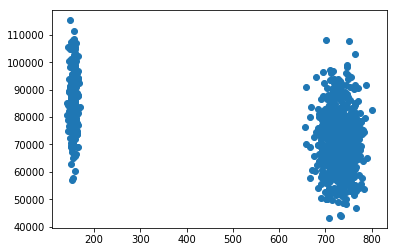

In [170]:
gre_df['gre_qnt']=np.ceil(gre_df['gre_qnt'])
Y=gre_df['salary_p4']
X=gre_df['gre_qnt']
plt.scatter(X, Y)

From the plot, it is very clear that GRE scores form two clusters- one at around 100 and another between 700 and 800.

This problem is most likely because of the changes in the GRE scoring system in the year 2011, where the range changed from to 200-800 to 130-170. If we leave these scores unchanged, the regression model is going to treat this variable as if it lay along the entire range of 130-800 uniformly. The plot clearly demonstrates that is not the case. Any inference based on the initial regression is likely to be highly inaccurate. 

This situation will require a scaling operation for the old score, where we divide and multiply by the maximums of the old and new scales respectively. Only then will all the values for the quantitative score be comparable.  

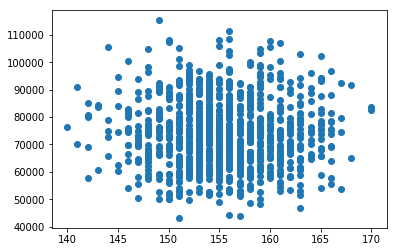

In [171]:
def rescale(row):
    if row['grad_year']<2011:
        return np.ceil(row['gre_qnt']*170/800)
    else:
        return row['gre_qnt']

gre_df['scaled']=gre_df.apply(rescale, axis=1)
Y=gre_df['salary_p4']
X=gre_df['scaled']
plt.scatter(X, Y)


Now the scores seem more evenly distributed and within the same range. This would make our subsequent regression estimates far more accurate. 

### c) Income after Graduation

Now let's consider the working of the salary variable. First, let's plot it against years.

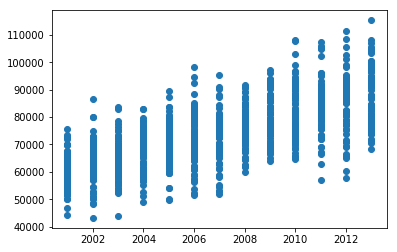

In [172]:
Y=gre_df['salary_p4']
X=gre_df['grad_year']
plt.scatter(X, Y)

As may be expected from data involving an element of time, we see the income levels rising over the years in the dataset. For every year, we see the mean as well as the distribution of points shift upward. This implies non-stationarity of the data, which violates the OLS assumption of no auto-correlation between values of x

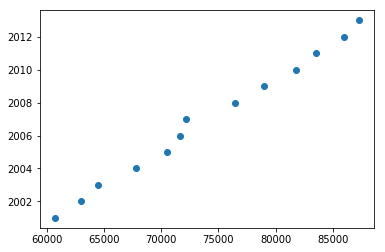

In [173]:
avg_inc_by_year = list(gre_df['salary_p4'].groupby(gre_df['grad_year']).mean().values)
X=avg_inc_by_year
years=sorted(list(set(gre_df['grad_year'])))
#print(years)
plt.scatter(X,years)

Indeed, as this plot demonstrates, the mean income is rising almost linearly across years. This would mean that the data are non-stationary, and  R-square values and t-statistics no longer follow the usual distributions. They would, in fact, be highly inflated. 

Since we don't have access to a longitudinal panel at the level of individuals, we cannot detrend this data. It would thus make sense to calculate the growth rate per year and then divide salary by that value.

In [174]:
income_vector= np.asarray(avg_inc_by_year)
avg_growth = (income_vector[1:] - income_vector[:-1])/(income_vector[:1].mean())
avg_growth=np.insert(avg_growth,0,0)
yearly_growth = dict(zip(years, avg_growth))

def detrend(row):
    return row['salary_p4']/(yearly_growth[row['grad_year']]+1)**(row['grad_year']-2001)

gre_df['true_salary']=gre_df.apply(detrend, axis=1)


Now that we've removed the trend, let's see how our salary data fares now on OLS asssumptions. 

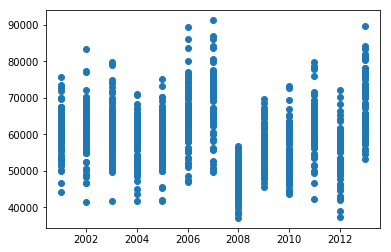

In [175]:
Y=gre_df['true_salary']
X=gre_df['grad_year']
plt.scatter(X, Y)

Now there is less of a clear upward rise over time. The mean income in fact, falls between 2007 and 2008, as would be historically expected with the US Financial Crisis. It seems like these data are now far more likely to meet OLS assumptions and generate reliable coefficient estimates. 

### d) Regression Review

Now with these changes implemented for the salary values and GRE scores, let's review their relationship with an OLS regression

In [176]:
Y=gre_df['true_salary']
X=gre_df['scaled']
X = sm.add_constant(X)
model=sm.OLS(Y,X)
results=model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            true_salary   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4256
Date:                Wed, 17 Oct 2018   Prob (F-statistic):              0.514
Time:                        10:45:31   Log-Likelihood:                -10515.
No. Observations:                1000   AIC:                         2.103e+04
Df Residuals:                     998   BIC:                         2.104e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.419e+04   8747.872      6.195      0.000     3.7e+04    7.14e+04
scaled        36.7061     56.264      0.652      0.514     -73.703     147.115
==============================================================================
Omnibus:                       11.065   Durbin-Watson:                   1.291
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.094
Skew:                           0.251   Prob(JB):                      0.00390
Kurtosis:                       3.118   Cond. No.                     4.82e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.82e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [177]:
results.params

const     54194.538109
scaled       36.706141
dtype: float64

In [178]:
results.bse

const     8747.871505
scaled      56.264018
dtype: float64

Now with our modified data, we find that the regression provides two different findings from the original:
1. The coefficient has fallen for the intercept term (from 89541.3 to 55587.008091). 
2. The relationship of higher intelligence with higher salary is no longer significant. (the p value is now a large 0.62)
3. The confidence interval includes negative values- which implies that higher intelligence could potentially be associated with a rise in income too! 
4. Standard errors have risen considerably across the board- from 878.763558 to 8721.6 for the intercept term, and from barely 1.36 to 56.169304 for the coefficient of GRE quantitative Scores. This implies that there is a lot more variability in the relationship between these variables than was initially apparent.

This means that we fail to reject the null hypothesis of no relationship between salary and GRE quantitative scores. 


## QUESTION THREE

Now it's time to explore the 2009 paper 'Origins of Homophily in an Evolving Social Network' by Kossinets and Watts. 

### a) The Research Question:
On what grounds (structural proximity, individual preference for similarity, etc.) and to what extent do individuals selectively make or break some ties over others, and how do these choices shed light on the observation that similar people are more likely to become acquainted than dissimilar people?



### b) The Data

##### i) Sources
The data set was constructed from 3 different data sources (each of which arose from databases): 
1. the logs of e-mail interactions within the university over one academic year
2. a database of individual attributes (status, gender, age, department, number of years in the community, etc.)
3. records of course registration, in which courses were recorded separately for each semester

The resulting data set combined longitudinal data with regards to the interaction, affiliation and attributes of all the parties involved- undergraduate and graduate students, faculty, and staff in a large U.S. university, who used
their university e-mail accounts to both send and receive messages.

##### ii) Observations
In terms of the number of participants, 30,396 individuals were observed. This study then analyzed 7,156,162 messages exchanged between them. 

##### iii)Time Period
The study was conducted over one academic year (about 270 days in this case)

##### iv) Documentation
The description of all these variables may be found in Appendix A, on Page 35-38 of the paper.


### c) Data Cleaning- Potential Problem

The study is remarkable for its selectivity of participants and emails in service of its objectives. However, this strength could also turn into a weakness if the research becomes too selective and leaves out several key dimensions and approaches. More specifically, it excludes participants at several levels. First, it focuses only on the interactions among members of the university population. This approach leaves out a critical dimension of relationships with the outside world. Second, it excluded 8979 members of that university population who were not necessarily regular email users across both semesters. Another 4,178 members were excluded on the grounds of not exchanging emails throughout the year. Finally, alumni whose new email addresses may have been available with the university were left out as they could no longer use those officiated by the university. 

The underlying logic of this sifting logic appears to be the frequency of interaction. Almost implicitly, the study seems to be assuming that social ties can only emerge with regular rather than sporadic communication. This could have been tested if the authors were to delve deeper into the specifics of each social relationship. However, the research approach leveraged here is more binary in its understanding. Either two individuals are connected on a network, or they are not. With this simple conceptualization, a larger number of the university population and the 'social relationships' between them could have been explored. The study thus falls short of its own goal in its attempts to narrow its scope.  

Furthermore, the email content itself was anonymized and not analyzed. While this helps uphold privacy of the participants, it stalls a deeper insight into the actual nature of conversations and the hypothesized 'social relationships'. 


### d) Match of Theoretical Construct and Data Source

The authors of this paper focus on the theoretical construct of 'social relationships' with explicit reference to the importance of time in understanding their dynamics. They state that such relationships for individuals can only be truly understood when placed in the context of all previous choices of environments and friends. This longitudinal aspect of social networks has poven challenging to capture empirically. The authors seek to address this concern through reliance on electronic network data- such as email communications, whose evolution can be monitored in real time and in a computationally rigorous manner. 

Of course, the mere presence of online communications by no means a guarantees such interactions offline. Depending on the cultural, geeographical or institutional setting, a large proportion of 'social relationships' may emerge in person and without mediation by any digital interface. Thus, two individuals may seem to be friends as per the email patterns laid down in the authors' research strategy. However, they need not have ever met in real life. Similarly, some strong associations may have formed without any such records detected online. 

The authors concede this point through reference to focal closure- one of the two primary mechanisms for the emergence of new ties. First, they rely on Feld's (1981) concept of 'social interaction foci', which are defined as the "various groups, contexts, and activities around which social life is organized and which in turn facilitate interpersonal interactions." The authors first turn to their data on officially recorded classes and treat them as 'explicit foci'that serve as visible and potentially important forums of interaction amongst most subgroups. This is the first instance of 'capturing' a real-world interaction that does not necessarilt rely on email networks. 

Crucially, they concede further that focal closure may operate through other avenues, such as social groups, sporting and cultural organizations, shared housing, etc. While there are little to no direct data available on these aspects, the authors rely on their previously discarded bulk email messages. They highlight that such emails imply shared affiliation, group, or
any activity that generates a demand for group-oriented communication. Due to this inferred nature of the interaction, the authors refer to such avenues as 'implicit foci'. They also further differentitate these foci into organized groups (that facilitate regular opportunities for interaction) and quasi groups (such as email lists and email lists). 

Thus, the authors begin with a seemingly narrow definition of 'social relationships' in the online realm. However, the collection of actual offline interactions could require more innovative uses of technology and potentially involve breaches of personal privacy (for example, tracking of mobile phone conversations or GPS records). Given the limited types of data available, I would conclude that the authors have fared commendably in encompassing a range of interaction types purely leveraging an email network. While the match between the theoretical construct and data science is not perfect, it is certainly an innovative and promising step in the right direction for computational social science. 

